In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=20, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [13]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
#     adadelta= Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=adadelta,
#                   metrics=['accuracy'])
    
    sgd = SGD(lr=3e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model



In [14]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 13s 555ms/step - loss: 0.7154 - acc: 0.5850 - val_loss: 0.4938 - val_acc: 0.8148
Epoch 2/100
24/24 [==============================] - 12s 508ms/step - loss: 0.5206 - acc: 0.7143 - val_loss: 0.3527 - val_acc: 0.8457
Epoch 3/100
24/24 [==============================] - 12s 511ms/step - loss: 0.3999 - acc: 0.8124 - val_loss: 0.3268 - val_acc: 0.8395
Epoch 4/100
24/24 [==============================] - 12s 512ms/step - loss: 0.3511 - acc: 0.8331 - val_loss: 0.2989 - val_acc: 0.8580
Epoch 5/100
24/24 [==============================] - 12s 514ms/step - loss: 0.3276 - acc: 0.8518 - val_loss: 0.2611 - val_acc: 0.8704
Epoch 6/100
24/24 [==============================] - 12s 498ms/step - loss: 0.2834 - acc: 0.8720 - val_loss: 0.2983 - val_acc: 0.8704
Epoch 7/100
24/24 [==============================] - 12s 499ms/step - loss: 0.2937 - acc: 0.8652 - val_loss: 0.3254 - val_acc: 0.8580
Epoch 8/100
24/24 [===============

24/24 [==============================] - 12s 495ms/step - loss: 0.1144 - acc: 0.9559 - val_loss: 0.2065 - val_acc: 0.9198
Epoch 62/100
24/24 [==============================] - 12s 494ms/step - loss: 0.1029 - acc: 0.9622 - val_loss: 0.2592 - val_acc: 0.9074
Epoch 63/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1227 - acc: 0.9499 - val_loss: 0.2443 - val_acc: 0.9074
Epoch 64/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1285 - acc: 0.9483 - val_loss: 0.2270 - val_acc: 0.9012
Epoch 65/100
24/24 [==============================] - 12s 494ms/step - loss: 0.1038 - acc: 0.9631 - val_loss: 0.2319 - val_acc: 0.9136
Epoch 66/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1244 - acc: 0.9493 - val_loss: 0.2463 - val_acc: 0.9136
Epoch 67/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1308 - acc: 0.9441 - val_loss: 0.2163 - val_acc: 0.9074
Epoch 68/100
24/24 [==============================] - 12s 496ms/step

Train loss: 0.124029410614
Train accuracy: 0.948024948025
Test loss: 0.142915828891
Test accuracy: 0.950310559006

===================FOLD= 2
Epoch 1/100
24/24 [==============================] - 14s 563ms/step - loss: 0.9656 - acc: 0.5704 - val_loss: 0.4602 - val_acc: 0.7578
Epoch 2/100
24/24 [==============================] - 12s 513ms/step - loss: 0.6021 - acc: 0.7295 - val_loss: 0.3333 - val_acc: 0.8447
Epoch 3/100
24/24 [==============================] - 12s 513ms/step - loss: 0.4381 - acc: 0.8013 - val_loss: 0.2914 - val_acc: 0.8634
Epoch 4/100
24/24 [==============================] - 12s 494ms/step - loss: 0.4208 - acc: 0.8069 - val_loss: 0.3119 - val_acc: 0.8509
Epoch 5/100
24/24 [==============================] - 12s 513ms/step - loss: 0.3869 - acc: 0.8210 - val_loss: 0.2398 - val_acc: 0.8696
Epoch 6/100
24/24 [==============================] - 12s 494ms/step - loss: 0.3410 - acc: 0.8524 - val_loss: 0.2719 - val_acc: 0.8758
Epoch 7/100
24/24 [==============================] - 1

Epoch 9/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2779 - acc: 0.8894 - val_loss: 0.2922 - val_acc: 0.8875
Epoch 10/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2623 - acc: 0.8910 - val_loss: 0.2483 - val_acc: 0.9062
Epoch 11/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2562 - acc: 0.8906 - val_loss: 0.2492 - val_acc: 0.8938
Epoch 12/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2197 - acc: 0.9134 - val_loss: 0.2986 - val_acc: 0.9000
Epoch 13/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2397 - acc: 0.9007 - val_loss: 0.2593 - val_acc: 0.9000
Epoch 14/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2547 - acc: 0.8964 - val_loss: 0.2251 - val_acc: 0.9062
Epoch 15/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2472 - acc: 0.8840 - val_loss: 0.2177 - val_acc: 0.9125
Epoch 16/100
24/24 [==============================] - 12

Epoch 34/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1707 - acc: 0.9309 - val_loss: 0.2230 - val_acc: 0.8938
Epoch 35/100
24/24 [==============================] - 12s 494ms/step - loss: 0.1786 - acc: 0.9261 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 36/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1826 - acc: 0.9256 - val_loss: 0.1368 - val_acc: 0.9500
Epoch 37/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1574 - acc: 0.9306 - val_loss: 0.1676 - val_acc: 0.9500
Epoch 38/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1608 - acc: 0.9313 - val_loss: 0.1484 - val_acc: 0.9437
Epoch 39/100
24/24 [==============================] - 12s 514ms/step - loss: 0.1651 - acc: 0.9288 - val_loss: 0.1345 - val_acc: 0.9500
Epoch 40/100
24/24 [==============================] - 12s 494ms/step - loss: 0.1627 - acc: 0.9363 - val_loss: 0.1515 - val_acc: 0.9500
Epoch 41/100
24/24 [==============================] - 1

Epoch 18/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2261 - acc: 0.9018 - val_loss: 0.2239 - val_acc: 0.9187
Epoch 19/100
24/24 [==============================] - 12s 497ms/step - loss: 0.2206 - acc: 0.9042 - val_loss: 0.2157 - val_acc: 0.9250
Epoch 20/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1950 - acc: 0.9202 - val_loss: 0.2076 - val_acc: 0.9062
Epoch 21/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1948 - acc: 0.9186 - val_loss: 0.2590 - val_acc: 0.8938
Epoch 22/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1988 - acc: 0.9182 - val_loss: 0.1989 - val_acc: 0.9187
Epoch 23/100
24/24 [==============================] - 12s 508ms/step - loss: 0.1895 - acc: 0.9260 - val_loss: 0.1650 - val_acc: 0.9375
Epoch 24/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2105 - acc: 0.9073 - val_loss: 0.2115 - val_acc: 0.9125
Epoch 25/100
24/24 [==============================] - 1

Epoch 35/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1696 - acc: 0.9308 - val_loss: 0.3114 - val_acc: 0.8812
Epoch 36/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1520 - acc: 0.9441 - val_loss: 0.3419 - val_acc: 0.8750
Epoch 37/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1846 - acc: 0.9252 - val_loss: 0.3354 - val_acc: 0.8688
Epoch 38/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1649 - acc: 0.9342 - val_loss: 0.3360 - val_acc: 0.8750
Epoch 39/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1744 - acc: 0.9298 - val_loss: 0.3063 - val_acc: 0.8875
Epoch 40/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1593 - acc: 0.9363 - val_loss: 0.3263 - val_acc: 0.8938
Epoch 41/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1580 - acc: 0.9319 - val_loss: 0.3429 - val_acc: 0.8812
Epoch 42/100
24/24 [==============================] - 1

Epoch 21/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2013 - acc: 0.9143 - val_loss: 0.2193 - val_acc: 0.8938
Epoch 22/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2051 - acc: 0.9119 - val_loss: 0.2215 - val_acc: 0.8812
Epoch 23/100
24/24 [==============================] - 12s 509ms/step - loss: 0.1886 - acc: 0.9130 - val_loss: 0.1916 - val_acc: 0.9125
Epoch 24/100
24/24 [==============================] - 12s 495ms/step - loss: 0.1943 - acc: 0.9137 - val_loss: 0.2134 - val_acc: 0.9125
Epoch 25/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1990 - acc: 0.9230 - val_loss: 0.2591 - val_acc: 0.8938
Epoch 26/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1957 - acc: 0.9226 - val_loss: 0.1992 - val_acc: 0.9125
Epoch 27/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1712 - acc: 0.9316 - val_loss: 0.1964 - val_acc: 0.8938
Epoch 28/100
24/24 [==============================] - 1

Epoch 15/100
24/24 [==============================] - 12s 495ms/step - loss: 0.2013 - acc: 0.9194 - val_loss: 0.3689 - val_acc: 0.8250
Epoch 16/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1998 - acc: 0.9173 - val_loss: 0.4088 - val_acc: 0.8438
Epoch 17/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2329 - acc: 0.9033 - val_loss: 0.3425 - val_acc: 0.8562
Epoch 18/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2012 - acc: 0.9202 - val_loss: 0.3410 - val_acc: 0.8500
Epoch 19/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2009 - acc: 0.9200 - val_loss: 0.3616 - val_acc: 0.8562
Epoch 20/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1987 - acc: 0.9182 - val_loss: 0.3328 - val_acc: 0.8313
Epoch 21/100
24/24 [==============================] - 12s 496ms/step - loss: 0.2053 - acc: 0.9225 - val_loss: 0.3378 - val_acc: 0.8500
Epoch 22/100
24/24 [==============================] - 1

In [15]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [16]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_SGD_10folds_3e-4_20p.csv', index=False)

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


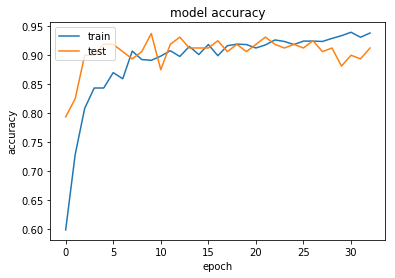

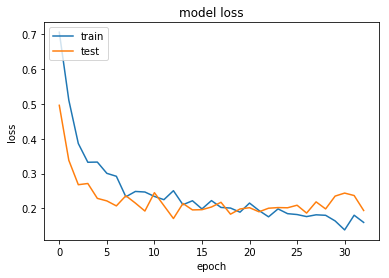

In [17]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [18]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [20]:
X_holdout2.shape

(160, 75, 75, 3)

In [21]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

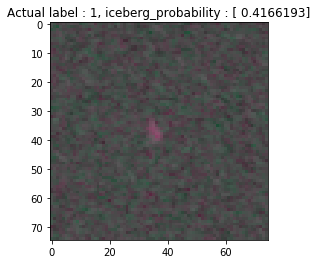

In [22]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

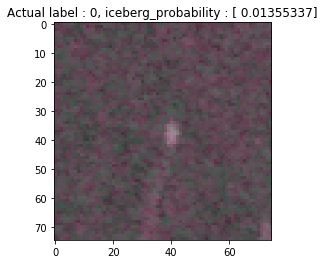

In [23]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

In [20]:
pred_valid.shape

(160, 1)

In [21]:
Y_holdout.shape

(160,)

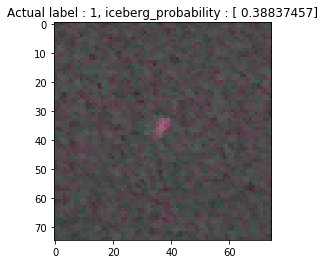

In [24]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

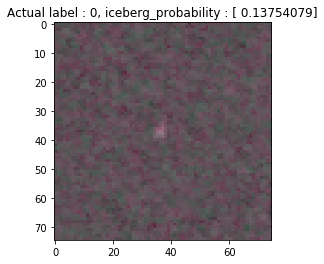

In [25]:
plt.imshow(X_holdout2[159], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[1602])+ ","+" iceberg_probability : "+str(pred_valid[159])
plt.title(tl)

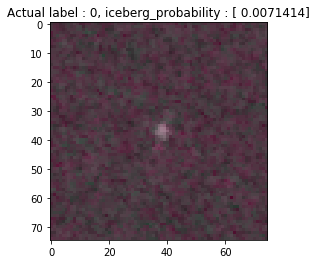

In [26]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

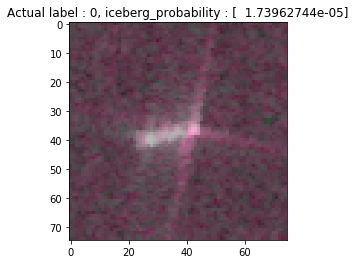

In [27]:
plt.imshow(X_holdout2[4], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[44])+ ","+" iceberg_probability : "+str(pred_valid[4])
plt.title(tl)

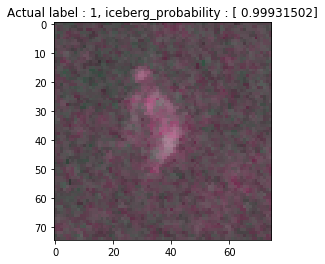

In [28]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

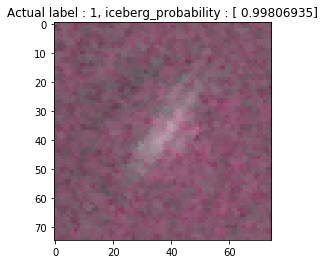

In [29]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)